# Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt


Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))


(60000, 32, 32)


Here is a simple datagenerator.

In [3]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [4]:
batchsize = 64
inputShape = (32,32,1)

In [32]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,80000)
val_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,40000)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,20000)

In [36]:
x_train, y_train = next(train_generator)

x_val, y_val = next(val_generator)
x_test, y_test = next(train_generator)

Let us look at some input-output pairs

(32, 32)
(80000, 32, 64)


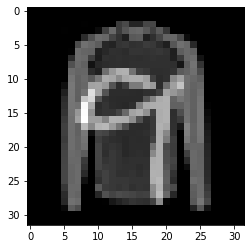

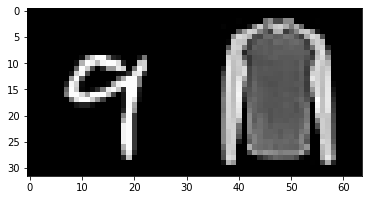

In [48]:
print(x_train[0].shape)
print(y_train.shape)
plt.imshow(x_train[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_train[0], cmap='gray', interpolation='nearest')
plt.show()


The neural network i chose to face this problem is UNET. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. This structure is one of the most preminent in segmentation tasks. The original architecture is proposed here: https://arxiv.org/abs/1505.04597
I tried different alternatives of UNET, but the best results are the ones that i reached refining the following: https://github.com/bnsreenu/python_for_microscopists/blob/master/204-207simple_unet_model.py.
To improve it, i decided to commenting some dropout layers, adding BatchNormalization layers before the relu activations, increase the filters size, and concatenate two output layers since for our task we need a 32x64 image.

In [7]:

from keras.models import Model
inputs = tf.keras.layers.Input(inputShape)

c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(inputs)

c1 = tf.keras.layers.Activation("relu")(c1)
c1 = tf.keras.layers.BatchNormalization()(c1)
#c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3),  padding='same')(c1)

c1 = tf.keras.layers.Activation("relu")(c1)
c1 = tf.keras.layers.BatchNormalization()(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3),  padding='same')(p1)

c2 = tf.keras.layers.Activation("relu")(c2)
c2 = tf.keras.layers.BatchNormalization()(c2)

#c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3),  padding='same')(c2)

c2 = tf.keras.layers.Activation("relu")(c2)
c2 = tf.keras.layers.BatchNormalization()(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3),  padding='same')(p2)

c3 = tf.keras.layers.Activation("relu")(c3)
c3 = tf.keras.layers.BatchNormalization()(c3)
#c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3),  padding='same')(c3)

c3 = tf.keras.layers.Activation("relu")(c3)
c3 = tf.keras.layers.BatchNormalization()(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3),  padding='same')(p3)
c4 = tf.keras.layers.Activation("relu")(c4)
c4 = tf.keras.layers.BatchNormalization()(c4)

#c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3),  padding='same')(c4)

c4 = tf.keras.layers.Activation("relu")(c4)
c4 = tf.keras.layers.BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(512, (3, 3),  padding='same')(p4)

c5 = tf.keras.layers.Activation("relu")(c5)
c5 = tf.keras.layers.BatchNormalization()(c5)

#c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu',  padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3),  padding='same')(u6)

c6 = tf.keras.layers.Activation("relu")(c6)
c6 = tf.keras.layers.BatchNormalization()(c6)
#c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3),  padding='same')(c6)
c7 = tf.keras.layers.Activation("relu")(c6)
c6 = tf.keras.layers.BatchNormalization()(c6)


u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)

c7 = tf.keras.layers.Activation("relu")(c7)
c7 = tf.keras.layers.BatchNormalization()(c7)
#c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3),  padding='same')(c7)

c7 = tf.keras.layers.Activation("relu")(c7)
c7 = tf.keras.layers.BatchNormalization()(c7)

u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3),   padding='same')(u8)

c8 = tf.keras.layers.Activation("relu")(c8)
c8 = tf.keras.layers.BatchNormalization()(c8)
#c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3),  padding='same')(c8)

c8 = tf.keras.layers.Activation("relu")(c8)
c8 = tf.keras.layers.BatchNormalization()(c8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3),  padding='same')(u9)

c9 = tf.keras.layers.Activation("relu")(c9)
c9 = tf.keras.layers.BatchNormalization()(c9)
#c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(c9)

c9 = tf.keras.layers.Activation("relu")(c9)
c9 = tf.keras.layers.BatchNormalization()(c9)

y_1 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

y_2 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

output = layers.Concatenate(axis=2)([y_1,y_2])

model = Model(inputs=[inputs], outputs=[output])
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['activation[0][0]']             
 alization)                                                                                   

Here i fit the model. 

In [49]:
filepath="/content/gdrive/My Drive/my_model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='loss', verbose=1, 
                                                save_best_only=True,
                                                mode='max')
callbacks_list = [checkpoint]

results = model.fit(x_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=64,
                    use_multiprocessing=True,
                    callbacks = callbacks_list,
                    steps_per_epoch=x_train.shape[0]/batchsize, 
                    validation_data=(x_val, y_val),
                    validation_batch_size=batchsize,
                    validation_steps=(x_val.shape[0]/batchsize))

Epoch 1/50
1248/1250 [============================>.] - ETA: 0s - loss: 0.1149 - mse: 1.6561e-04
Epoch 1: loss improved from -inf to 0.11493, saving model to /content/gdrive/My Drive/my_model
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/my_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/my_model/assets


1250/1250 [==============================] - 43s 34ms/step - loss: 0.1149 - mse: 1.6560e-04 - val_loss: 0.1169 - val_mse: 6.2459e-04
Epoch 2/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.1149 - mse: 1.6511e-04
Epoch 2: loss did not improve from 0.11493
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1149 - mse: 1.6510e-04 - val_loss: 0.1169 - val_mse: 6.3490e-04
Epoch 3/50
1250/1250 [==============================] - ETA: 0s - loss: 0.1149 - mse: 1.6429e-04
Epoch 3: loss did not improve from 0.11493
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1149 - mse: 1.6429e-04 - val_loss: 0.1168 - val_mse: 6.1525e-04
Epoch 4/50
1249/1250 [============================>.] - ETA: 0s - loss: 0.1149 - mse: 1.6238e-04
Epoch 4: loss did not improve from 0.11493
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1149 - mse: 1.6238e-04 - val_loss: 0.1168 - val_mse: 6.1955e-04
Epoch 5/50
1249/1250 [==========================

In [53]:
MSEs = []
for i in range(10):
  x_test, y_test = next(test_generator)
  mse = model.evaluate(x_test, y_test)[1]
  MSEs.append(mse)
  
print(np.std(MSEs))


625/625 [==============================] - 4s 7ms/step - loss: 0.1176 - mse: 6.4932e-04
3.80261587260337e-06


Let's see some output results.

 1/32 [..............................] - ETA: 0sWARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 32 batches). You may need to use the repeat() function when building your dataset.


32/32 [==============================] - 0s 748us/step


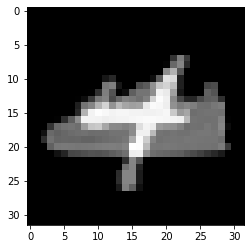

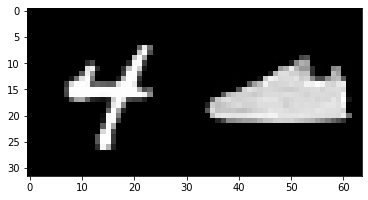

In [55]:
x_test, y_test = next(test_generator)
t = x_test[0].reshape(1,32,32,1)
y_t = y_test[0]

res = model.predict(t, 
                    batch_size=batchsize, 
                    verbose = 1,
                    steps = 32)

plt.imshow(x_test[0],cmap='gray', interpolation='nearest')
plt.show()

plt.imshow(np.squeeze(res[0]), cmap='gray', interpolation='nearest')
plt.show()



Here i saved the model on my drive.

In [25]:
from tensorflow.keras.models import Model
from google.colab import drive
drive.mount('/content/gdrive')
#model.save('./gdrive/MyDrive/my_Newmodel')
model = tf.keras.models.load_model('./gdrive/MyDrive/my_Newmodel')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
model.save_weights('./gdrive/MyDrive/lastWeights3.h5')

In [ ]:
model.load_weights('./gdrive/MyDrive/lastWeights2.h5')